# Install torch 2.3.0 + cu121 to ensure reproducibility

In [1]:
# !pip install torch==2.3.0+cu121 # for reproducibility only

# Get package from GitHub

In [2]:
!git clone https://github.com/zcheng-a/LCD_kNN # load package from github
from LCD_kNN import LCD_kNN as lk

Cloning into 'LCD_kNN'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 93 (delta 26), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (93/93), 7.64 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (26/26), done.


# Load standard package

In [3]:
### main package
import numpy as np
import torch
print(torch.__version__)
import torch.nn as nn
# import torch.nn.functional as F

### check if device is GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is:', device)
print(torch.cuda.get_device_name(0))

### set seed
np.random.seed(0)
torch.manual_seed(0)

### Auxiliary
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

# Set the custom color cycle for plt.plot
unique_colors =  [
    '#1a6691', '#e5670a', '#268227', '#b52224', '#7d4e99',
    '#774c41', '#c565a1', '#6a6868', '#a1a31d', '#1587af',
    '#43719d', '#d67c4c', '#549456', '#c16d70', '#8c7a9d',
    '#977468', '#d7a2be', '#969696', '#c5c85e', '#4ea9bf'
]

2.3.0+cu121
device is: cuda
NVIDIA L4


# Prepare data

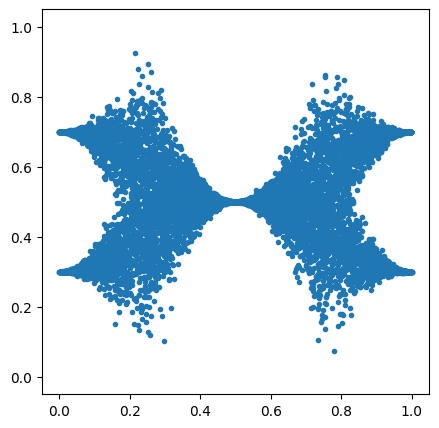

In [4]:
d_X = 1
d_Y = 1
n_data = int(1e4)
mdl = 1 ### 1 for Model 1, other values for Model 2

if mdl == 1:
    x_data = torch.rand(n_data, d_X, device=device)
    y_data = 0.2 / 2 * (1+torch.cos(2*torch.pi*x_data)) + 0.12 * (1 - torch.abs(torch.cos(2*torch.pi*x_data))) * torch.randn(n_data, d_Y, device=device)
    y_data = y_data * 2 * (torch.randint(0, 2, size=(n_data,1), device=device) - 0.5) + 0.5
else:
    x_data = torch.rand(n_data, d_X, device=device)
    indx_x = x_data < 0.5
    y_data = torch.rand(n_data, d_Y, device=device)
    y_data[indx_x] = 0.5 * y_data[indx_x]
    y_data[~indx_x] = 0.5 + 0.5 * y_data[~indx_x]

data_tensor = torch.cat((x_data,y_data), 1)

plt.figure(figsize=(5,5))
plt.plot(x_data.detach().cpu().numpy(), y_data.detach().cpu().numpy(), '.')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.show()

# Train LipNet

In [5]:
# hyper-parameters
k = 100
nns_type = ' ' ### other than 'rbsp', use exact nearest neighor serach
n_iter = int(5e3)+1
n_batch = 100
L = 0.1
tau = 1e-3
bool_sparse = True
gamma_sparse = 0.5


# initialize LipNet
knn_lip = lk.LearnCondDistn_kNN(d_X, d_Y, data_tensor)
knn_lip.init_net_lip(n_atoms=k, n_neurons=2*k, n_layers=5, L=L, input_actvn=nn.ReLU(), hidden_actvn=nn.ReLU(), L_requires_grad=False)

if knn_lip.atomnet.L.requires_grad:
    optimizer_lip = torch.optim.Adam([
        {'params': knn_lip.atomnet.input_fc.parameters(), 'lr': 1e-3},
        {'params': knn_lip.atomnet.hidden_layers.parameters(), 'lr': 1e-3},
        {'params': knn_lip.atomnet.output_fc.parameters(), 'lr': 1e-3},
        {'params': knn_lip.atomnet.L, 'lr': 1e-2}
        ])
else:
    optimizer_lip = torch.optim.Adam(knn_lip.atomnet.parameters(), lr=1e-3)

In [6]:
# train LipNet
loss_lst_lip = []
n_nan = 0

t_start = time.time()
for i in range(n_iter):
    knn_lip.atomnet.train()

    ## compute loss
    if i <= 100: ### in case of nan
        knn_lip.set_compute_loss_param(k, n_batch=n_batch, n_iter_skh=5, one_over_eps=1, nns_type=nns_type)
    elif i <= 500:
        knn_lip.set_compute_loss_param(k, n_batch=n_batch, n_iter_skh=5, one_over_eps=10, nns_type=nns_type)
    else:
        knn_lip.set_compute_loss_param(k, n_batch=n_batch, n_iter_skh=10, one_over_eps=20, bool_sparse=bool_sparse, gamma_sparse=gamma_sparse, nns_type=nns_type)

    loss = knn_lip.compute_loss()

    ## Step
    if torch.isnan(loss):
        n_nan = n_nan + 1
        continue
    optimizer_lip.zero_grad()
    loss.backward()
    optimizer_lip.step()
    if knn_lip.lip_bool: ### normalize constants related to continuity
        knn_lip.atomnet.update_nor(mmt_inoutweight=tau, mmt_uh=tau, p_update=1)

    ## print loss
    if i % 100 == 0:
        clear_output(wait=True)
        display('Training progress:' + str(i) + '/' + str(n_iter-1))
        # print(i, 'loss:', loss.item())
        # print()
        loss_lst_lip.append(loss.item())

t_end = time.time()
print("This cell takes %.2f seconds." % (t_end-t_start))

'Training progress:5000/5000'

This cell takes 47.03 seconds.


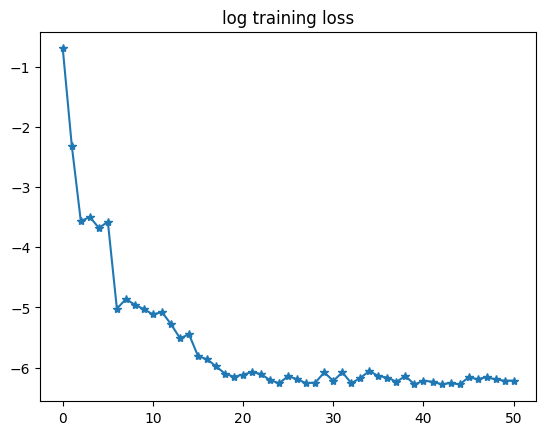

Number of nan loss: 0


In [7]:
plt.plot(np.log(np.array(loss_lst_lip)),'*-')
plt.title('log training loss')
plt.show()
print("Number of nan loss: " + str(n_nan))

# Plot outcomes of trained lip net

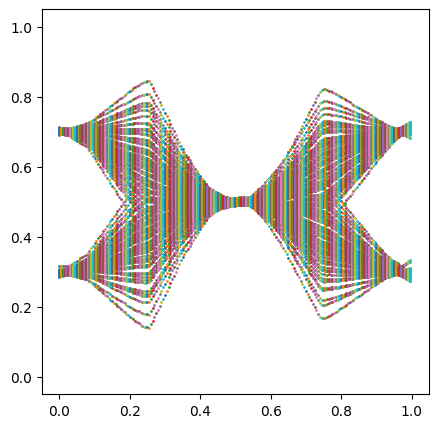

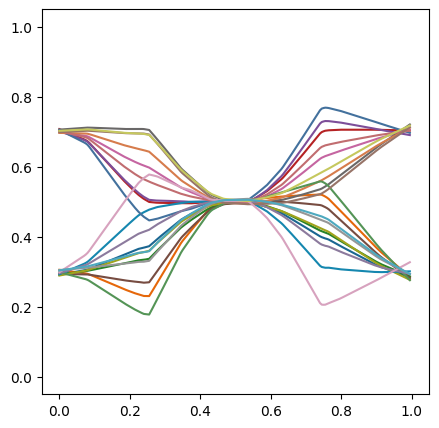

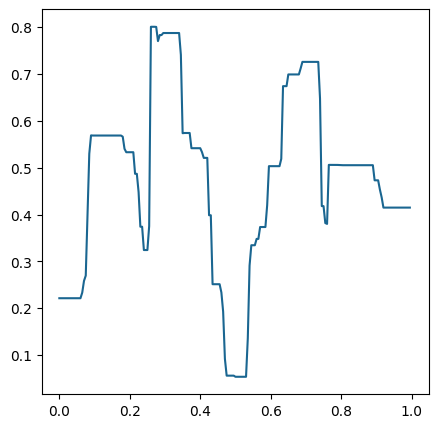

In [8]:
knn_lip.atomnet.eval()

n_plot = 200

x_plot = 1 / n_plot * torch.arange(n_plot, device=device).view(-1,1)
x_plot.requires_grad = True
y_plot = knn_lip.atomnet(x_plot)

plt.rcdefaults()
plt.figure(figsize=(5,5))
for i in range(n_plot):
    x_ = x_plot[i,0] * torch.ones(y_plot.shape[1], device=device)
    y_ = y_plot[i, :, 0]
    plt.plot(x_.detach().cpu().numpy(), y_.detach().cpu().numpy(), '.', markersize=2)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.show()

n_atoms_plot = 20
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=unique_colors)
plt.figure(figsize=(5,5))
for j in range(n_atoms_plot):
    plt.plot(x_plot.detach().cpu().numpy(), y_plot.detach().cpu().numpy()[:, j,0], '-')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.show()

# gradient
grads_plot = torch.zeros(n_plot, device=device)
for j in range(knn_lip.atomnet.n_atoms):
    grads_plot = grads_plot + torch.abs( torch.autograd.grad(y_plot[:,j,0], x_plot, grad_outputs=torch.ones_like(y_plot[:,j,0]), create_graph=False, retain_graph=True)[0] )
grads_plot = grads_plot / knn_lip.atomnet.n_atoms

plt.figure(figsize=(5,5))
plt.plot(x_plot.detach().cpu().numpy()[:,0], grads_plot.detach().cpu().numpy()[:,0])
plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.85])
plt.show()

# Plot conditional CDFs at different x's

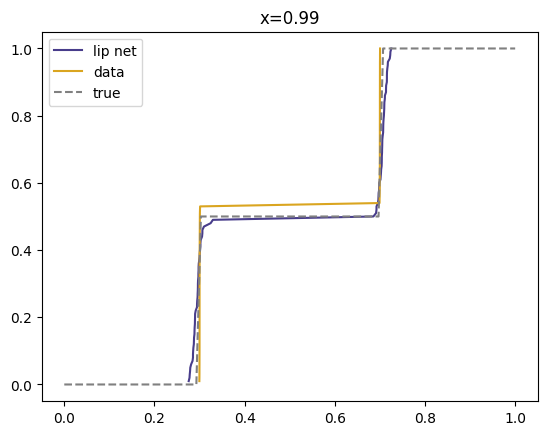

In [9]:
x = torch.tensor([[0.99]], device=device)
# x = torch.rand(1, 1, device=device)
n_atoms = knn_lip.atomnet.n_atoms
y_net = knn_lip.atomnet(x)

## plot cdf according to lip net
atoms_net = y_net[0, :, 0].sort()[0]
plt.plot(atoms_net.detach().cpu().numpy(), np.arange(n_atoms+1)[1:]/n_atoms, color='darkslateblue', label='lip net')


# plot cdf according to data
indx_near = torch.abs(data_tensor[:, 0] - x.item()).sort()[1][:k]
y_near = data_tensor[:,1][indx_near].sort()[0]
plt.plot(y_near.detach().cpu().numpy(), np.arange(k+1)[1:]/k, color='goldenrod', label='data')

# plot cdf according to model
x_plot = torch.linspace(0,1,100, device=device)
if mdl == 1:
    mean = 0.2 /2 * (1+torch.cos(2*torch.pi*x)) * torch.tensor([1,-1], device=device)
    std = 0.12 * (1 - torch.abs(torch.cos(2*torch.pi*x))) * torch.tensor([1,1], device=device)
    cdf = torch.distributions.normal.Normal(loc=mean.view(-1,1), scale=std.view(-1,1)).cdf
    cdf_plot = cdf(x_plot - 0.5).sum(0) / 2
else:
    cdf_plot = torch.minimum(torch.maximum(2 * (x_plot - 0.5 * (x>0.5)), torch.tensor(0, device=device)), torch.tensor(1, device=device))[0]
plt.plot(x_plot.detach().cpu().numpy(), cdf_plot.detach().cpu().numpy(), '--', color='grey', label='true')



plt.title('x=%.2f' % x.item())
plt.legend()
plt.show()

# Plot all W

In [10]:
def compute_W(atoms_, CDF_true, n_int=2000, device=device):
    y_min, y_max = torch.min(atoms_), torch.max(atoms_)
    y_int = torch.linspace(y_min, y_max, n_int, device=device)
    cdf_est = (atoms_.view(1,-1) <= y_int.view(-1,1)).sum(-1) / atoms_.shape[0]
    cdf_true = CDF_true(y_int)
    ## trapzoidal
    abs_diff = (cdf_est - cdf_true).abs()
    return ((abs_diff[:-1] + abs_diff[1:])).sum() / 2 / n_int * (y_max-y_min)

In [11]:
time_start = time.time()

N_q = 200
x_q = torch.linspace(0.0, 1.0, N_q, device=device).view(-1,1)
dt_tensor = data_tensor

# prepare atoms from raw k-NN estimator
k_lst = [100, 300, 1000]
atoms_raw = []
for k_ in k_lst:
    atoms_raw.append(torch.zeros(size=[N_q, k_],device=device))
for i in range(N_q):
    indx_temp = (dt_tensor[:,0] - x_q[i,0]).abs().sort(-1)[1]
    for j in range(len(k_lst)):
        k_ = k_lst[j]
        atoms_raw[j][i] = dt_tensor[indx_temp[:k_], 1]

# prepare atoms from net
with torch.no_grad():
    y_lip = knn_lip.atomnet(x_q)

# collect projected W errors
W1_all = []
for _ in range(len(k_lst)+1):
    W1_all.append(torch.zeros(N_q, device=device))

for i in range(N_q):

    if mdl == 1:
        def CDF_true(y, x_=x_q[i]):
            if x_<1e-3 or x_>=1-1e-3:
                return (y>=0.3) * 0.5 + (y>=0.7) * 0.5
            elif x_>=0.5-1e-3 and x_<=0.5+1e-3:
                return (y>=0.5) * 1
            else:
                mean_ = 0.1 * (1 + torch.cos(2*torch.pi*x_))
                std_ = 0.12 * (1 - torch.abs(torch.cos(2*torch.pi*x_)))
                cdf1 = torch.distributions.normal.Normal(loc=0.5+mean_, scale=std_).cdf
                cdf2 = torch.distributions.normal.Normal(loc=0.5-mean_, scale=std_).cdf
                return ( cdf1(y) + cdf2(y) ) / 2
    else:
        def CDF_true(y, x_=x_q[i]):
            if x_ < 0.5:
                return (y<0.5) * 2 * y + (y>=0.5) * 1
            else:
                return (y>=0.5) * 2 * (y-0.5)

    for j in range(len(k_lst)):
        W1_all[j][i] = compute_W(atoms_raw[j][i], CDF_true)
    W1_all[-1][i] = compute_W(y_lip[i,:,0], CDF_true)

time_end = time.time()
print("This cell takes %.2f seconds." % (time_end-time_start))

This cell takes 0.93 seconds.


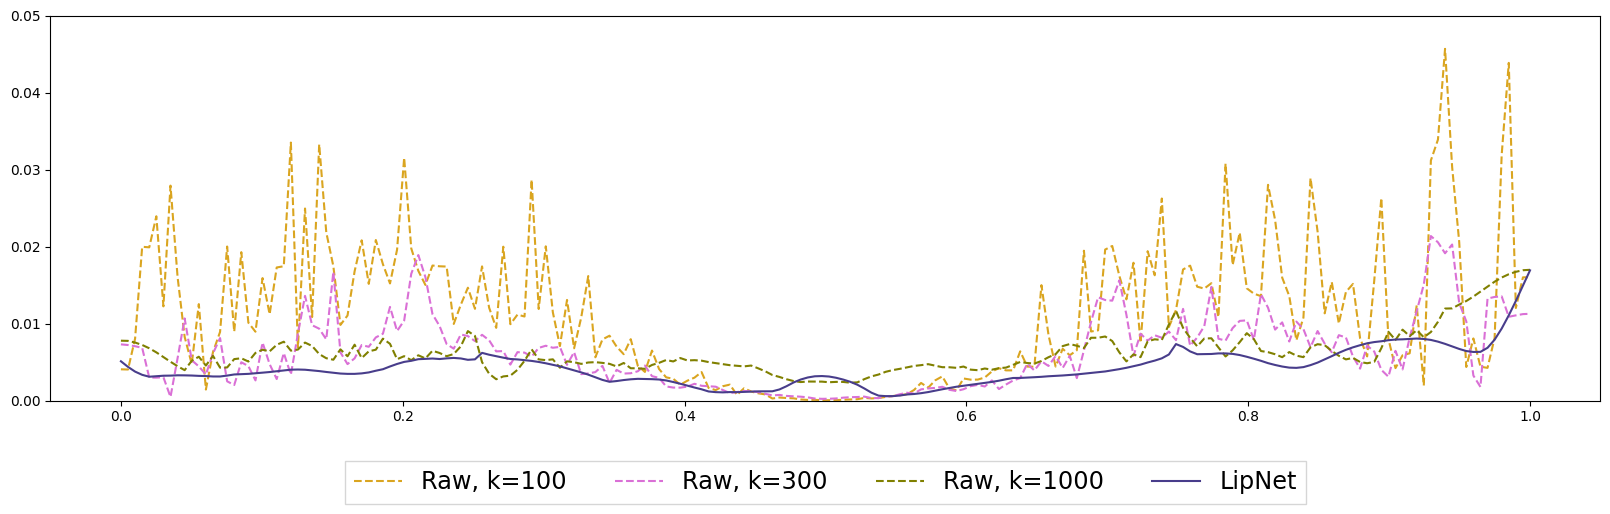

In [12]:
n = 4
colors= ['goldenrod', 'orchid', 'olive', 'darkslateblue']
linestyles= ['--','--','--','-']
labels = ['Raw, k=100', 'Raw, k=300', 'Raw, k=1000', 'LipNet']

plt.figure(figsize=(20,5))
for i in range(n):
    plt.plot(x_q.detach().cpu().numpy(), W1_all[i].detach().cpu().numpy(), linestyle=linestyles[i], color=colors[i], label=labels[i])

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), fancybox=False, shadow=False, ncol=10, fontsize='xx-large')
plt.ylim(([0,0.05]))
plt.show()

In [13]:
# # y_lip[-2].sort(0)[0]
# y_ = y_lip[-1,:,0].sort(0)[0]
# print(y_[49])
# print()
# print(((y_[:50]-0.3).abs().sum() + (y_[50:]-0.7).abs().sum()) / y_.shape[0])

In [14]:
y_ = y_lip[-1,:,0].sort(0)[0]
cdf_true = (y_>=0.3) * 0.5 + (y_>=0.7) * 0.5
cdf_est = (torch.arange(k, device=device) + 1) / k
abs_diff = (cdf_true-cdf_est).abs()
print(torch.sum(abs_diff[:48] * (y_[:48]-y_[1:49]).abs()))

tensor(0.0069, device='cuda:0')


In [15]:
print(torch.sum(y_<0.3))
print(torch.sum(y_<0.7))

tensor(38, device='cuda:0')
tensor(60, device='cuda:0')
